# Ekofisk stereo video WDM test
Use WDM to estimate directional spectrum from Ekofisk stereo video data.

In [30]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
from pywdm import wdm

# Read Ekofisk test stereo data
datadir = '/home/mikapm/Documents/EKOK'
fn_nc = os.path.join(datadir, 'xygrid_50cm_20210406_1620_plane_sub.nc')
ds = xr.open_dataset(fn_nc, decode_coords='all')
# Change sign of y coord
ds = ds.assign_coords(ym=ds.y * (-1))
ds

<xarray.Dataset>
Dimensions:  (time: 5756, x: 280, y: 300)
Coordinates:
  * time     (time) datetime64[ns] 2021-04-06T16:20:00.061401 ... 2021-04-06T...
  * x        (x) float32 -70.0 -69.5 -69.0 -68.5 -68.0 ... 68.0 68.5 69.0 69.5
  * y        (y) float32 -200.0 -199.5 -199.0 -198.5 ... -52.0 -51.5 -51.0 -50.5
    ym       (y) float32 200.0 199.5 199.0 198.5 198.0 ... 52.0 51.5 51.0 50.5
Data variables:
    xgrid    (x, y) float32 ...
    ygrid    (x, y) float32 ...
    eta      (time, x, y) float32 ...

Pick array of grid cells in stereo field of view and calculate distances and angles.

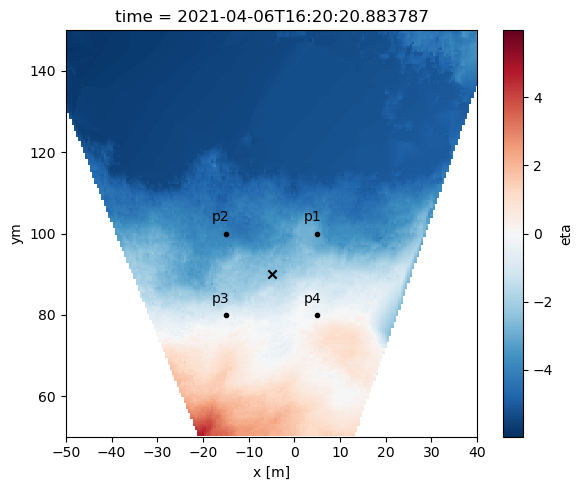

In [19]:
# x,y coordinates of square array
origin = (-5, 90) # x,y coordinates of array origin
sidelen = 10 # array half side length
xpts = [origin[0]+sidelen, origin[0]-sidelen, 
        origin[0]-sidelen, origin[0]+sidelen]
ypts = [origin[1]+sidelen, origin[1]+sidelen, 
        origin[1]-sidelen, origin[1]-sidelen]

# Define A and R arrays for stereo array
# See figure below for visualization of array geometry.
a_p1 = 45 # Angle from origin to p1 (see figure)
a_p2 = 135
a_p3 = 225
a_p4 = 315
# Angles from center
A = np.array([a_p1, a_p2, a_p3, a_p4]).astype(float)
# Convert angles to radians
A *= (np.pi / 180)
# Radius of array (m). i.e. Polar coordinates of the staffs
o_l1 = np.sqrt(sidelen**2 + sidelen**2) # Distance from origin to p1 (see plot)
o_l2 = np.sqrt(sidelen**2 + sidelen**2)
o_l3 = np.sqrt(sidelen**2 + sidelen**2)
o_l4 = np.sqrt(sidelen**2 + sidelen**2)
R = np.array([o_l1, o_l2, o_l3, o_l4])
# Make virtual wave staff array (interpolate over NaNs)
arr = np.array([ds.eta.sel(x=xpts[0], y=ypts[0], method='nearest').interpolate_na(dim='time').bfill(
    dim='time').ffill(dim='time').values, 
                ds.eta.sel(x=xpts[1], y=ypts[1], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values, 
                ds.eta.sel(x=xpts[2], y=ypts[2], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values,
                ds.eta.sel(x=xpts[3], y=ypts[3], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values,
               ]) 

# Plot array on top of sample grid for visualization
fig, ax = plt.subplots(figsize=(6,5))
ds.isel(time=100).eta.plot(ax=ax, x='x', y='ym')
for i, (xp, yp) in enumerate(zip(xpts, ypts)):
    ax.scatter(xp, yp, color='k', marker='.')
    # Name points p1-p4
    ax.annotate(f'p{i+1:0d}', xy=(xp-3, yp+3), )
# Mark origin w/ x
ax.scatter(origin[0], origin[1], color='k', marker='x')
# Crop limits
ax.set_ylim([50, 150])
ax.set_xlim([-50, 40])
plt.tight_layout()
plt.show()

Plot array time series.

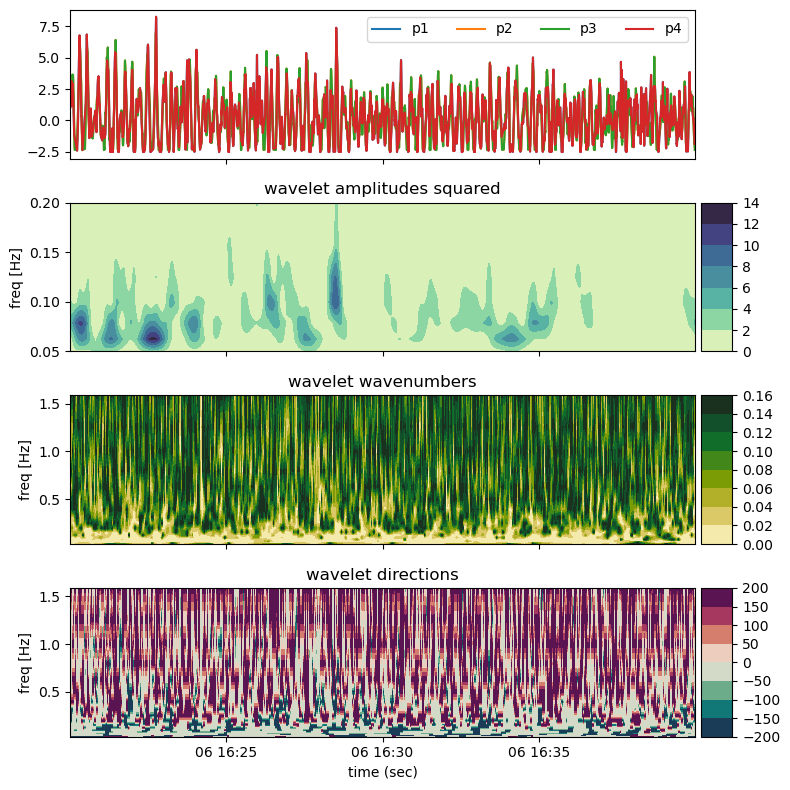

Estimate WDM spectrum and plot.

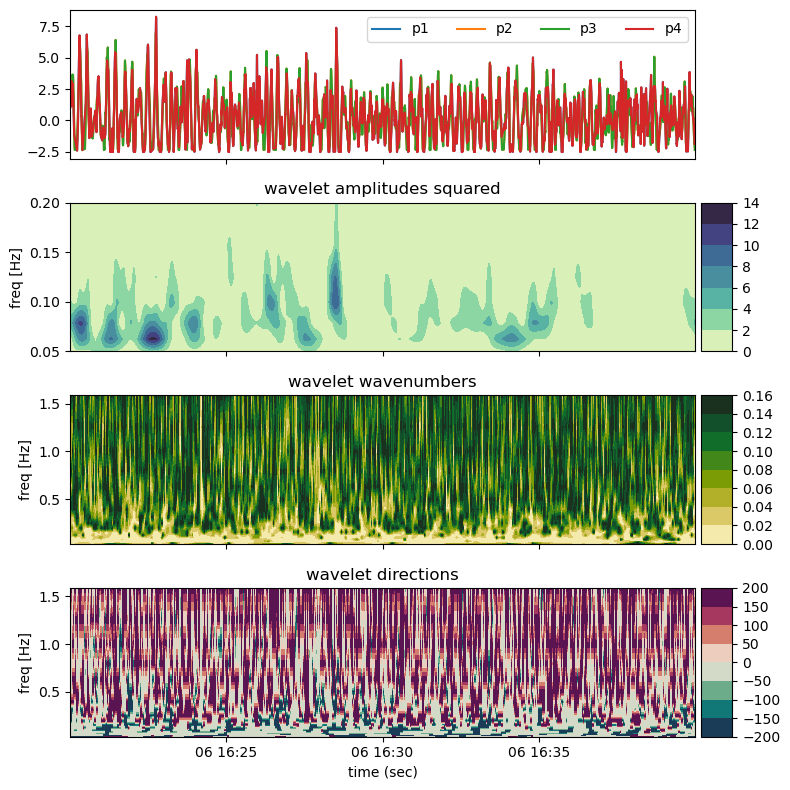

In [38]:
# Initialize WDM class using default parameters
WDM = wdm.WaveletDirectionalMethod(A, R, lf=0.05, hf=0.8, nv=3)
# Run WDM algorithm
Amp, K, Th, freqs = WDM.wdm_kth(arr.T)
# Get f-theta and f spectra
Efd, S = WDM.spec_fth(Amp, Th*(180/np.pi), freqs, res=10)
res = 10
dirs = np.arange(0, 360, res)

# Plot time series and wavelet amplitudes^2, wavenumbers and directions
fig, axes = plt.subplots(figsize=(8,8), nrows=4, sharex=True)
ims = {} # dict for images for colorbars
# Time axis
t = ds.sel(x=xpts[i], y=ypts[i], method='nearest').interpolate_na(dim='time').bfill(
        dim='time').ffill(dim='time').time.values
# Plot array time series on top
for i in range(4):
    axes[0].plot(t, arr[i], label=f'p{i+1:0d}')
axes[0].set_xlabel(None)
axes[0].set_title(None)
axes[0].legend(loc='upper right', ncol=4)
# Row 2: Wavelet amplitudes ^ 2
ims['1'] = axes[1].contourf(t, freqs, Amp**2, cmap=cmocean.cm.deep)
axes[1].set_ylim([0.05, 0.2])
axes[1].set_title('wavelet amplitudes squared')
axes[1].set_ylabel('freq [Hz]')
# Row 3: Wavelet wavenumbers
ims['2'] = axes[2].contourf(t, freqs, K, cmap=cmocean.cm.speed)
axes[2].set_ylabel('freq [Hz]')
axes[2].set_title('wavelet wavenumbers')
# Row 4: Wavelet directions
ims['3'] = axes[3].contourf(t, freqs, np.rad2deg(Th), cmap=cmocean.cm.curl)
axes[3].set_ylabel('freq [Hz]')
axes[3].set_xlabel('time (sec)')
axes[3].set_title('wavelet directions')
# Colorbars
for i,ax in enumerate(axes[1:]):
    cax = axes[i+1].inset_axes([1.01, 0.00, 0.05, 1.0], transform=axes[i+1].transAxes)
    fig.colorbar(ims[f'{i+1:0d}'], cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()
plt.close()

Plot spectra.

dth:  0.17453292519943295
